<a href="https://colab.research.google.com/github/Bryan-Az/ContrastTransferLabs/blob/main/Supervised_Contrastive_Learning/Classification_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

github path: Supervised_Contrastive_Learning/Classification_CV.ipynb

# Classification in Computer Vision (without Supervised Contrastive Learning or Loss)

In [1]:
import keras
from keras import layers

In [2]:

import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import losses

# Preparing the Data

In [3]:
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 7s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Data Augmentation Pipeline
This augmentation pipeline consists of a sequential model with neural network layers that apply transformations onto the input data to increase the data's underlying patterns. Normalization is applied onto the weight's contained within the model to make the inputs initially equally contribute to the output of the next layers. RandomFlip applies a random horizontal flip to some images, and RandomRotation applies a 2% rotation on the images to avoid overfitting the model on angles that are overly represented within the data.

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

# The Image Classification Model: Encoder and Classification Sub-Models

As opposed to Supervised Contrastive Learning (SCL), this classification model will not train its' encoder 'model' seperately. It will incorporate the encoder as a submodule of the classifier. It also will not use the NPairs_Loss function (used for training a classification of a SCL model), but instead use the softmax loss, commonly used for multi-class classification, where each image is matched to only one label.

In [5]:
from tensorflow.keras.callbacks import Callback

In [6]:
def create_encoder():
    '''
    this function loads a residual network without the top layers and returns a keras model
    that can be used for encoding images.
    '''
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model

class LossHistory(Callback):
    def __init__(self):
        self.losses = []  # List to store losses

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            self.losses.append(logs.get('loss'))  # Append loss

## A Dimensionality-reducing Image Encoder Model

In [7]:
encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 10
dropout_rate = 0.5
temperature = 0.05

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23564807 (89.89 MB)
Trainable params: 23519360 (89.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________


## The Classifier Model

In [8]:
def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(), # sparse categorical cross-entropy is used as opposed to N_Pairs Loss
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [9]:
encoder = create_encoder() #encoer was note trained seperately
classifier = create_classifier(encoder) # the encoder is added to the model, the model is extending it
classifier.summary() # both encoder and model are trained as one

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functiona  (None, 2048)              23564807  
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                

### Visualizing the Loss of the Previously Un-Trained Encoder & Classifier Combo

In [10]:
classifier_losses = history.history['loss']

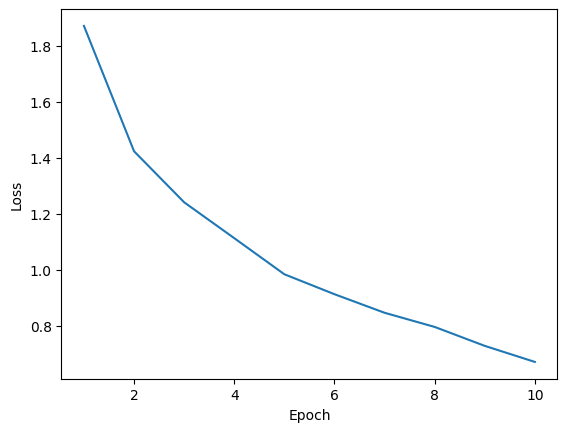

In [18]:
import matplotlib.pyplot as plt
# plotting the saved_losses, each bin of 189 losses is an epoch, flattened
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, classifier_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Conclusion
In the SCL image classification notebook, the final model accuracy and loss after 10 epochs of training is around 79% and 0.61, respectively.

In this non-SCL image classification notebook, the final model accuracy and loss after 10 epochs of training is around 77% and 0.67, respectively.

This shows that the SCL architecture has the ability to improve the performance of a model trained for image classification when compared to the traditional baseline architecture. Although I only trained the two models for 10 epochs each - further training may show a bigger difference between the two models.